## Data loading

To work with any kind of data we first have to load it. For this we use a dataloader that reads the images as well as their labels and transforms them into pytorch readable tensors.

In [1]:
import pathlib

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

In [2]:
class RSiMCCDataset(Dataset):
    def __init__(self, transform=None):
        super().__init__()
        self.transform = transform
        # get images
        image_files = [x.resolve() for x in pathlib.Path(".").glob('data/*/*')]
        # Image.open() has a bug, this is a workaround
        self.images=[read_image(str(p)) for p in image_files] 
        # get labels from image path
        labels = [x.parts[-2] for x in image_files]
        self.classes = sorted(list(set(labels)))
        self.labels = [self.label_to_tensor(lbl) for lbl in labels]

        assert len(self.labels) == len(self.images), f"Found {len(self.labels)} labels and {len(self.images)} images"

    def label_to_tensor(self, lbl):
        """
        Converts the string label to a one-hot tensor where every entry is zero except the label which is one.
        
        """
        assert lbl in self.classes, f"Class {lbl} not a valid class (valid classes: {self.classes})"
        t = torch.zeros(len(self.classes))
        t[self.classes.index(lbl)] = 1
        return t

    def tensor_to_label(self, t):
        """
        Returns the classname in string format
        """
        assert len(t.shape) == 1, f"Can only convert 1-dimensional tensors (shape of tensor: {t.shape})"
        assert len(t) == len(self.classes), f"Lenght of tensor ({len(t)}) does not match number of classes ({len(classes)})"
        return self.classes[t.argmax()]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx].float()/255
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

## Examples
Now lets load the dataset and look at some examples by just randomly loading the images and their labels

In [3]:
dataset = RSiMCCDataset()

In [4]:
print(f"The dataset consists of {len(dataset)} RGB images of shape {dataset.images[0].shape} labeled in {dataset.labels[0].shape[0]} classes which are " + ', '.join(dataset.classes))

The dataset consists of 11519 RGB images of shape torch.Size([3, 64, 64]) labeled in 10 classes which are AnnualCrop, Forest, HerbaceousVegetation, Highway, Industrial, Pasture, PermanentCrop, Residential, River, SeaLake


In [5]:
dataset.labels[0]

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

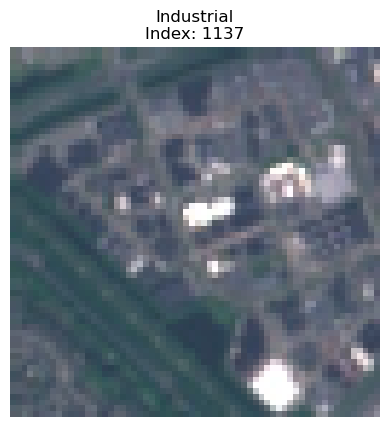

In [6]:
import matplotlib.pyplot as plt
import random

r = random.randint(0, len(dataset))
img, lbl = dataset[r]

# Display the image
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.title(dataset.tensor_to_label(lbl) + "\nIndex: " + str(r))
plt.show()

In [7]:
dataset.labels[0]

dataset[0][0].shape

torch.Size([3, 64, 64])

# Create my custom convolution model for the task

In [ ]:
class SimpleCNN_11(nn.Module): # 83% val_acc after 30 epochs
    def __init__(self, nb_classes):
        super(SimpleCNN_11, self).__init__()
        # inputs (N,3,64,64)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=6)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, padding = 2)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5)
        self.relu4 = nn.ReLU()

        self.conv5 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5)
        self.relu5 = nn.ReLU()
        self.bn5 = nn.BatchNorm2d(16)

        self.conv6 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5)
        self.relu6 = nn.ReLU()
        self.pool6 = nn.MaxPool2d(kernel_size=2, stride=2)


        self.lin1  = nn.Linear(16*7*7, 128) # adapt here!
        self.lin2  = nn.Linear(128, nb_classes)
        
    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(x + self.conv2(x))
        x = self.bn2(x)
        x = self.relu3(self.conv3(x))
        x = self.pool3(x)

        x = self.relu4(self.conv4(x))
        x = self.relu5(self.conv5(x))
        x = self.bn5(x)
        x = self.relu6(self.conv6(x))
        x = self.pool6(x) # outputs (None, 16, 7, 7)

        x = self.lin1(x.view(-1, 16*7*7))  # adapt here!
        x = self.lin2(x)

        return x

In [93]:
class SimpleCNN12(nn.Module):
    def __init__(self, nb_classes):
        super(SimpleCNN12, self).__init__()
        # inputs (N,3,64,64)
        # Follows ResNET architecture: Conv2d -> BN -> ReLU (-> MaxPool)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=6, padding=2)
        self.bn1   = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        # no pooling in 1st step

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, padding=2)
        self.bn2   = nn.BatchNorm2d(16)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, padding=2)
        self.bn3   = nn.BatchNorm2d(16)
        self.relu3 = nn.ReLU()
        # no pooling in 3rd step


        self.conv4 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, padding=2)
        self.bn4   = nn.BatchNorm2d(16)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)



        self.lin1  = nn.Linear(16*15*15, nb_classes) # adapt here!

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = x + self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = x + self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        x = x + self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.pool4(x)
        # outputs (None, 16, 15, 15)

        x = self.lin1(x.view(-1, 16*15*15))  # adapt here!


        return x


In [94]:
def get_model(nb_classes):
    return SimpleCNN12(nb_classes)

In [95]:
# Create a dummy image to test input of the network
dummy_img = torch.zeros(42, 3, 64, 64)
model = get_model(len(dataset.classes))
model(dummy_img).shape

torch.Size([42, 10])

### Initialize the model and dataloader

In [96]:
""" from sklearn.model_selection import train_test_split

# Split dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create data loaders for training and validation sets
train_dataset = MyDataset(X_train, y_train)
val_dataset = MyDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) """

' from sklearn.model_selection import train_test_split\n\n# Split dataset into training and validation sets\nX_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# Create data loaders for training and validation sets\ntrain_dataset = MyDataset(X_train, y_train)\nval_dataset = MyDataset(X_val, y_val)\ntrain_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)\nval_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) '

In [97]:
# Create training and validation datasets
from torch.utils.data import random_split

batch_size = 50
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

data_loader = DataLoader(dataset, batch_size=50, shuffle=True)

train_features, train_labels = next(iter(data_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")


num_classes = len(dataset.classes)
model = get_model(num_classes) # define the model
# model.load_state_dict(torch.load("best_model.pt"))


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


image = torch.randn(20, 3, 64, 64) # create dummy image
output = model(image)

print(model(image).shape) # show the output of one batch of images

from torchinfo import summary
summary(model) # display summary of the model and number of trainable parameters

Feature batch shape: torch.Size([50, 3, 64, 64])
Labels batch shape: torch.Size([50, 10])
torch.Size([20, 10])


Layer (type:depth-idx)                   Param #
SimpleCNN12                              --
├─Conv2d: 1-1                            1,744
├─BatchNorm2d: 1-2                       32
├─ReLU: 1-3                              --
├─Conv2d: 1-4                            6,416
├─BatchNorm2d: 1-5                       32
├─ReLU: 1-6                              --
├─MaxPool2d: 1-7                         --
├─Conv2d: 1-8                            6,416
├─BatchNorm2d: 1-9                       32
├─ReLU: 1-10                             --
├─Conv2d: 1-11                           6,416
├─BatchNorm2d: 1-12                      32
├─ReLU: 1-13                             --
├─MaxPool2d: 1-14                        --
├─Linear: 1-15                           36,010
Total params: 57,130
Trainable params: 57,130
Non-trainable params: 0

### Send the model to the GPU

In [98]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SimpleCNN12(
  (conv1): Conv2d(3, 16, kernel_size=(6, 6), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (conv4): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lin1): Linear(in_features=3600, out_features=10, bias=True)
)

### Define the training function

In [99]:
def train(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    best_val_acc = 0.0
    for epoch in range(num_epochs):
        # Training
        running_loss = 0.0
        correct = 0
        total = 0
        for batch, (X, y) in enumerate(train_loader):
            # Move tensors to the configured device
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()

            # Compute prediction and loss
            pred = model(X)

            # Compute loss and its gradients
            loss = loss_fn(pred, y)
            loss.backward()
            

            # Backpropagation step
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(pred.data, 1)
            total += y.size(0)
            correct += (predicted == y.argmax(1)).sum().item()

            # Display progress
            if batch % 30 == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"Epoch {epoch+1}, batch {batch+1}/{len(train_loader)}, loss: {loss:.4f}")
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        print(f"Epoch {epoch+1}, train loss: {train_loss:.4f}, train accuracy: {train_acc:.2f}%")

        # Validation

        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch, (X, y) in enumerate(val_loader):
                X, y = X.to(device), y.to(device)
                pred = model(X)
                loss = loss_fn(pred, y)
                running_loss += loss.item()
                _, predicted = torch.max(pred.data, 1)
                total += y.size(0)
                correct += (predicted == y.argmax(1)).sum().item()
            val_loss = running_loss / len(val_loader)
            val_acc = 100 * correct / total
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            print(f"Epoch {epoch+1}, val loss: {val_loss:.4f}, val accuracy: {val_acc:.2f}%")
        
            # # Save best model
            # if val_acc > best_val_acc:
            #     best_val_acc = val_acc
            #     torch.save(model.state_dict(), "best_model.pt")

    return train_losses, train_accs, val_losses, val_accs



In [100]:
train_losses, train_accs, val_losses, val_accs = train(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=30)

Epoch 1, batch 1/185, loss: 2.4545


Epoch 1, batch 31/185, loss: 1.4883
Epoch 1, batch 61/185, loss: 1.2766
Epoch 1, batch 91/185, loss: 1.0548
Epoch 1, batch 121/185, loss: 0.9032
Epoch 1, batch 151/185, loss: 0.7817
Epoch 1, batch 181/185, loss: 0.8054
Epoch 1, train loss: 1.1783, train accuracy: 58.05%
Epoch 1, val loss: 0.8279, val accuracy: 71.35%
Epoch 2, batch 1/185, loss: 0.5670
Epoch 2, batch 31/185, loss: 0.6374
Epoch 2, batch 61/185, loss: 0.6694
Epoch 2, batch 91/185, loss: 0.5544
Epoch 2, batch 121/185, loss: 0.4827
Epoch 2, batch 151/185, loss: 0.5471
Epoch 2, batch 181/185, loss: 0.5393
Epoch 2, train loss: 0.7443, train accuracy: 74.67%
Epoch 2, val loss: 0.7248, val accuracy: 75.30%
Epoch 3, batch 1/185, loss: 0.6138
Epoch 3, batch 31/185, loss: 0.5256
Epoch 3, batch 61/185, loss: 0.7437
Epoch 3, batch 91/185, loss: 0.3931
Epoch 3, batch 121/185, loss: 0.7034
Epoch 3, batch 151/185, loss: 0.6978
Epoch 3, batch 181/185, loss: 0.4634
Epoch 3, train loss: 0.6055, train accuracy: 79.16%
Epoch 3, val loss: 0.

In [ ]:
torch.save(model.state_dict(), "best_model.pt")

In [75]:
import matplotlib.pyplot as plt

def plot_loss_accuracy2(train_losses, val_losses, train_accs, val_accs):
    # Create figure and axes
    fig, ax1 = plt.subplots(figsize=(8, 4))
    ax2 = ax1.twinx()

    # Plot loss curves
    ax1.plot(train_losses, label="Training Loss", color="blue")
    ax1.plot(val_losses, label="Validation Loss", color="orange")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper left")

    # Plot accuracy curves
    ax2.plot(train_accs, label="Training Accuracy", color="green")
    ax2.plot(val_accs, label="Validation Accuracy", color="red")
    ax2.set_ylabel("Accuracy (%)")
    ax2.legend(loc="upper right")

    # Set common x-axis label and grid
    ax1.set_xlabel("Epoch")
    ax1.grid()

    plt.show()

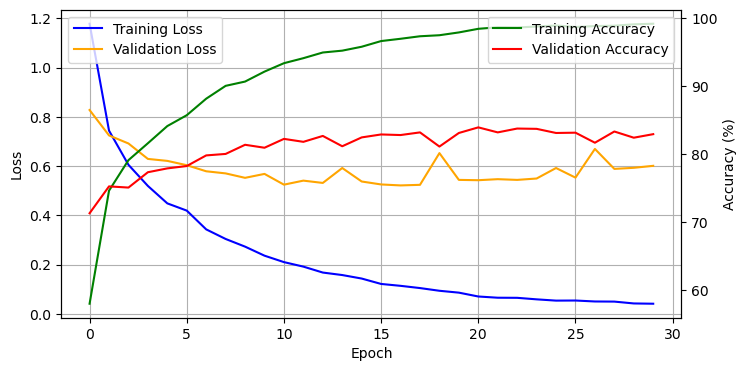

In [101]:
plot_loss_accuracy2(train_losses, val_losses, train_accs, val_accs)